HR ANALYTICS
===
A company which is active in Big Data and Data Science wants to hire data scientists conduct a training program for aspirants. Many people signed up for their training and the company wants to know which of these candidates really wants to work for them after training or are looking for a new employment because it helps to reduce the cost and time including the quality of training or planning the courses and categorization of candidates. Information related to demographics, education, experience from candidates are from the signup and enrollment data.

# Libraries

In [59]:
# import pandas to be able to use dataframes
import pandas as pd

# import plotting library
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sn

# allow inline plotting on notebook cells
%matplotlib inline

# gives us access to numpy functions
import numpy as np

# allows us to implement a an impute strategy
from sklearn.impute import SimpleImputer

#from scipy.stats import chisquare

# allows us to implement a train test split strategy
from sklearn.model_selection import train_test_split

# access to the logistic regression class of Sklearn
from sklearn.linear_model import LogisticRegression

# model metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve,roc_auc_score

# recursive feature elimination, helps in prioritizing features
from sklearn.feature_selection import RFE

# model persistence
from joblib import dump, load

# Exploration

In [2]:
# load training data
training_df = pd.read_csv("data/aug_train.csv")

In [3]:
# let's look at some sample files
training_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


Features
===
* enrollee_id : Unique ID for enrollee
* city: City code
* citydevelopmentindex: Developement index of the city (scaled)
* gender: Gender of enrolee
* relevent_experience: Relevent experience of enrolee
* enrolled_university: Type of University course enrolled if any
* education_level: Education level of enrolee
* major_discipline :Education major discipline of enrolee
* experience: Enrolee total experience in years
* company_size: No of employees in current employer's company
* company_type : Type of current employer
* lastnewjob: Difference in years between previous job and current job
* training_hours: training hours completed
* target: 0 – Not looking for job change, 1 – Looking for a job change

In [4]:
# Let's look at some sample data and see how it aligns to the data dictionary
training_df[training_df['company_type'] =='Funded Startup'].head(1).T

,4
enrollee_id,666
city,city_162
city_development_index,0.767
gender,Male
relevent_experience,Has relevent experience
enrolled_university,no_enrollment
education_level,Masters
major_discipline,STEM
experience,>20
company_size,50-99


In [5]:
# Let's look at some statistics
training_df.describe(include = 'all')

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
count,19158.000000,19158,19158.000000,14650,19158,18772,18698,16345,19093,13220,13018,18735,19158.000000,19158.000000
unique,NaN,123,NaN,3,2,3,5,6,22,8,6,6,NaN,NaN
top,NaN,city_103,NaN,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,NaN,NaN
freq,NaN,4355,NaN,13221,13792,13817,11598,14492,3286,3083,9817,8040,NaN,NaN
mean,16875.358179,NaN,0.828848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,65.366896,0.249348
std,9616.292592,NaN,0.123362,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60.058462,0.432647
min,1.000000,NaN,0.448000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.000000
25%,8554.250000,NaN,0.740000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.000000,0.000000
50%,16982.500000,NaN,0.903000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,0.000000
75%,25169.750000,NaN,0.920000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.000000,0.000000


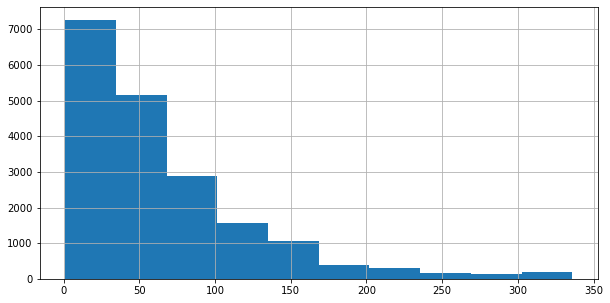

In [6]:
training_df['training_hours'].hist(figsize=(10,5))

In [7]:
# there are 10 objects (strings/categorical) and 4 numerical features
training_df.dtypes.value_counts()

object     10
float64     2
int64       2
dtype: int64

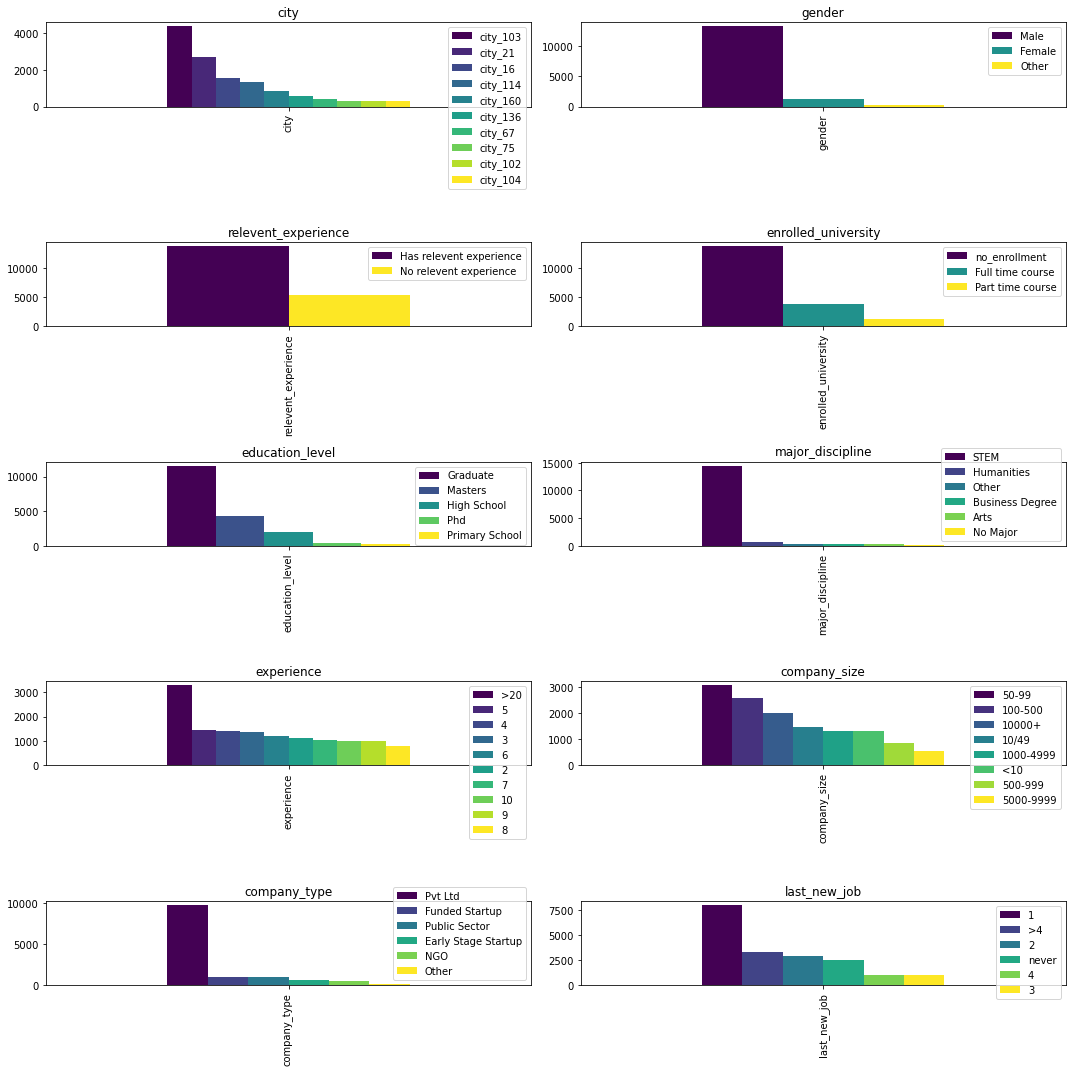

In [8]:
# let's create simple code that will loop thru all categorical values and plot their distribution (up to the top 10 values)

f, axs = plt.subplots(5,2, figsize=(15,15))
axs = axs.ravel()
j = 0

for i in training_df.columns:
    series = training_df[i]
    tmp_df = pd.DataFrame(series.value_counts())
    tmp_df = tmp_df.head(10).T

    if(series.dtype == 'object'):
        tmp_df.plot.bar(ax=axs[j],title=i,cmap="viridis")
        j+=1
plt.tight_layout()
plt.show()

# Target

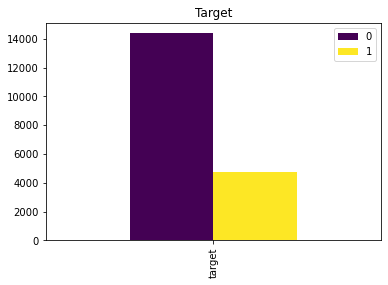

In [9]:
# Let's look at the target variable and how the attributes are distributed with respect to it

tmp_df = pd.DataFrame(training_df['target'].value_counts().reset_index(drop=True)).T
tmp_df.plot.bar(title="Target",cmap="viridis")

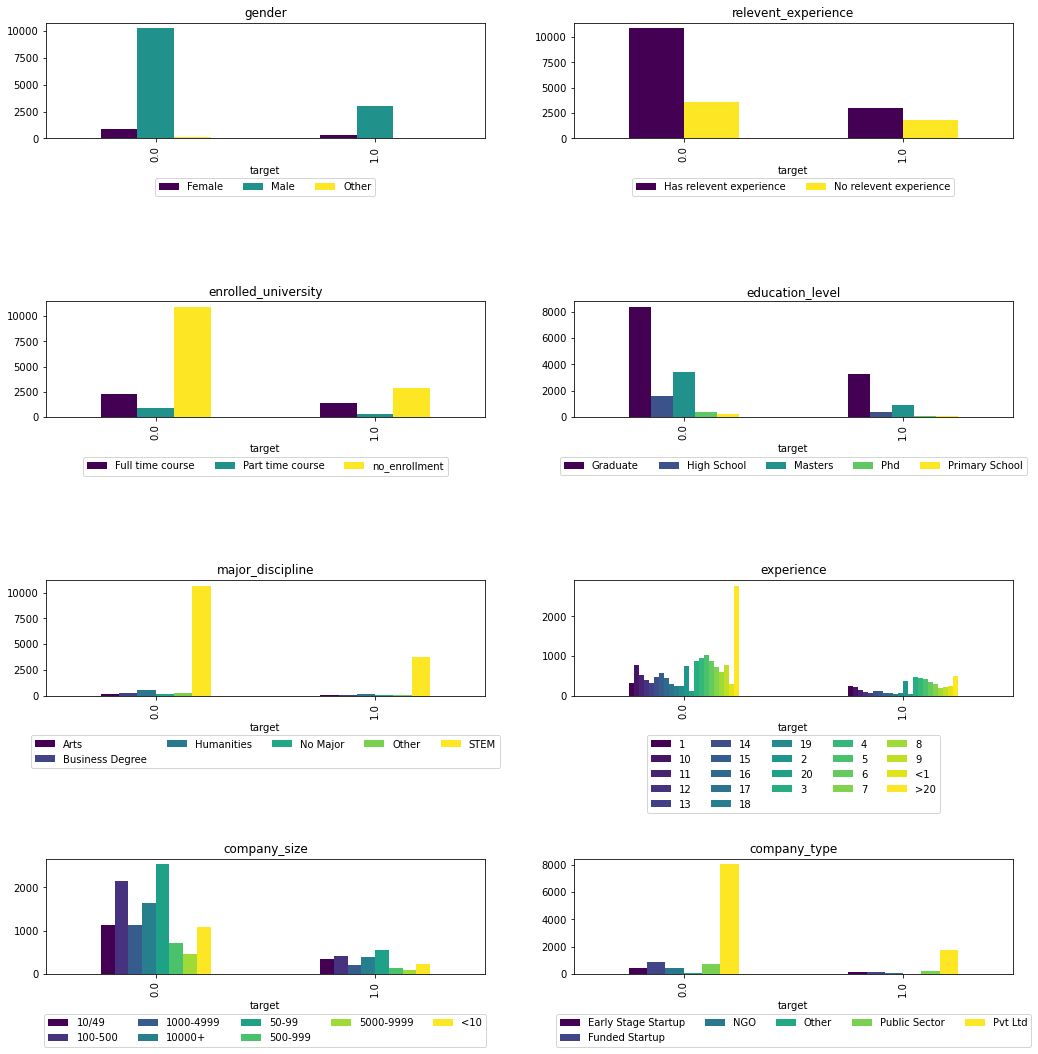

In [10]:
# Let's take a look at how the distribution looks like with respect to the target

fig = plt.figure(figsize=(15,15))

j = 0
ignore_list = ['target','enrollee_id','city','city_development_index']

for i in training_df.columns:

    if(series.dtype == 'object' or (i not in ignore_list and j<8) ):
        
        fig.add_subplot(421+j)
        ax_list = fig.axes
        
        tmp_df = pd.pivot_table(training_df,index="target",values="enrollee_id",columns=i,aggfunc="count")
        tmp_df.plot.bar(ax=ax_list[j],title=i,cmap="viridis")
        ax_list[j].legend(loc='upper center', bbox_to_anchor=(0.5, -0.30), ncol=5)
        j+=1
        
fig.tight_layout() 
plt.show()

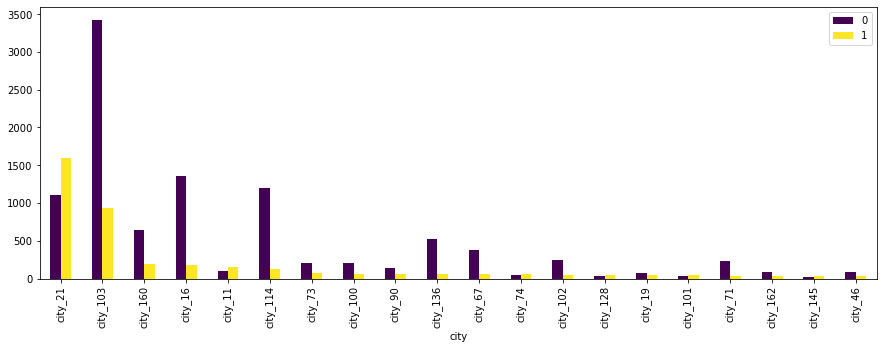

In [11]:
tmp_df = pd.pivot_table(training_df[['target','enrollee_id','city']],index="city",columns="target",aggfunc="count")
tmp_df.columns = [0,1]
tmp_df.columns.index = 'city'
tmp_df = tmp_df.sort_values(1,ascending=False)
tmp_df[0:20].plot.bar(cmap="viridis",figsize=(15,5))

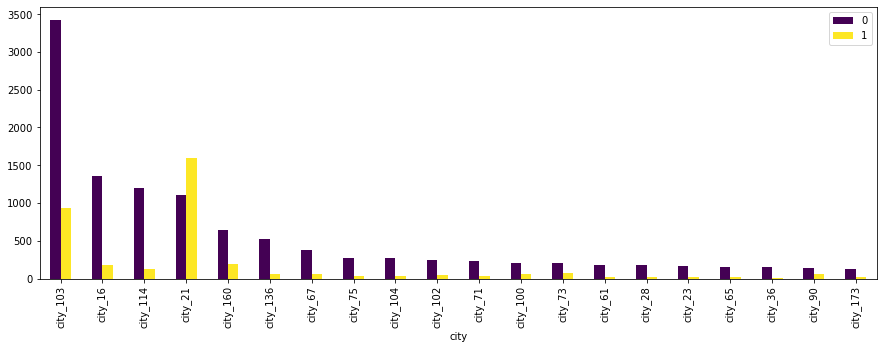

In [12]:
tmp_df = pd.pivot_table(training_df[['target','enrollee_id','city']],index="city",columns="target",aggfunc="count")
tmp_df.columns = [0,1]
tmp_df.columns.index = 'city'
tmp_df = tmp_df.sort_values(0,ascending=False)
tmp_df[0:20].plot.bar(cmap="viridis",figsize=(15,5))

City development index
===
The City Development Index was developed for the Second United Nations Conference on Human Settlements (Habitat II) in 1996 and measures the level of development in cities. The Urban Indicators Programme of the United Nations Human Settlements Programme (UN-Habitat) developed the indicator so that they could rank cities of the world according to their level of development and as a display of indicators depicting development. The CDI cuts across the different clusters identified in the Urban Indicator Framework as it is based on five sub indices namely, infrastructure, waste, health, education and city product. It is useful as it provides a snap-shot view of how cities are doing with respect to the different indices. It was invented by Dr Joe Flood, first Coordinator of the Urban Indicators Program, following a statistical analysis of city indicators data.
Reference :https://en.wikipedia.org/wiki/City_development_index

![Computation](img/Calculation-of-CDI-by-UN-HABITAT-GUIP-Index-Formula.png)

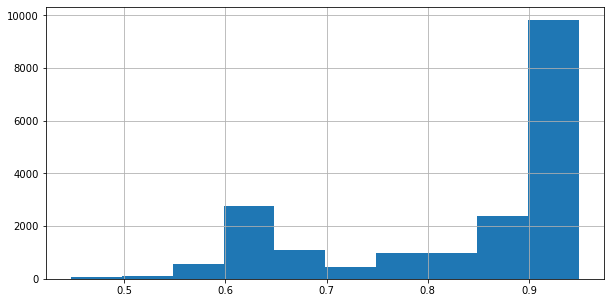

In [13]:
training_df['city_development_index'].hist(figsize=(10,5))

In [14]:
training_df[['city_development_index','city']].drop_duplicates().sort_values('city_development_index',ascending=False)[0:20]

,city_development_index,city
112,0.949,city_98
61,0.939,city_75
183,0.939,city_28
15,0.926,city_114
157,0.925,city_89
115,0.925,city_97
41,0.924,city_104
49,0.923,city_83
903,0.921,city_167
6,0.920,city_160


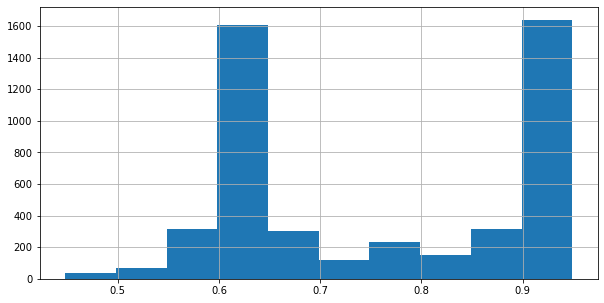

In [15]:
tmp_df = training_df[training_df['target']==1]
tmp_df['city_development_index'].hist(figsize=(10,5))

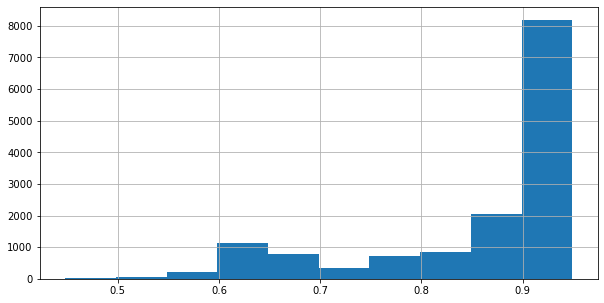

In [16]:
tmp_df = training_df[training_df['target']==0]
tmp_df['city_development_index'].hist(figsize=(10,5))

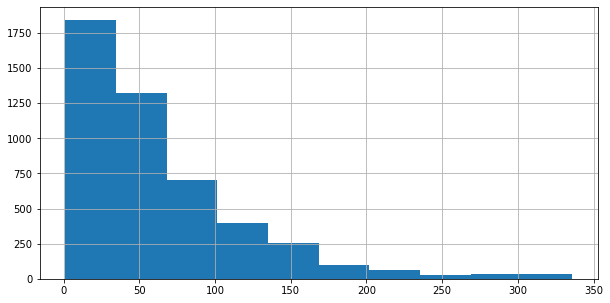

In [17]:
tmp_df = training_df[training_df['target']==1]
tmp_df['training_hours'].hist(figsize=(10,5))

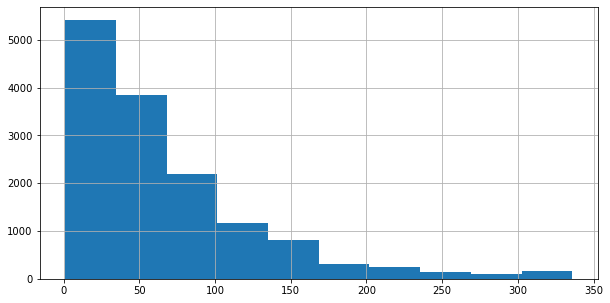

In [18]:
tmp_df = training_df[training_df['target']==0]
tmp_df['training_hours'].hist(figsize=(10,5))

# Correlation

We need to find a good idea of what feature to prioritize on our initial base model before we do any sort of optimization. Let's do some basic correlation tests to find out which have influences tha target variable

In [19]:
# Numerical Correlation using Pearson

corrMatrix=training_df[["city","city_development_index","gender","relevent_experience","enrolled_university","education_level",
                   "major_discipline","experience","company_size","company_type","last_new_job","training_hours","target"]].corr()

corrMatrix

,city_development_index,training_hours,target
city_development_index,1.000000,0.001920,-0.341665
training_hours,0.001920,1.000000,-0.021577
target,-0.341665,-0.021577,1.000000


In [20]:
training_df.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

# Preprocessing

In [21]:
# How many null values do we have per column?

training_df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

In [22]:
# Let's deal with these null values by replacing them with the most frequent value per column

imp_mean = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
tmp = imp_mean.fit_transform(training_df)
tmp_df = pd.DataFrame(tmp)
tmp_df.columns = training_df.columns
tmp_df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.92,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1,36,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0
2,11561,city_21,0.624,Male,No relevent experience,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,never,83,0
3,33241,city_115,0.789,Male,No relevent experience,no_enrollment,Graduate,Business Degree,<1,50-99,Pvt Ltd,never,52,1
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0


In [23]:
# do we still have any null values
processed_training_df = tmp_df.copy()
processed_training_df.isnull().sum()

enrollee_id               0
city                      0
city_development_index    0
gender                    0
relevent_experience       0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [24]:
# convert features that should be numerical

processed_training_df["target"] = pd.to_numeric(processed_training_df["target"])
processed_training_df["city_development_index"] = pd.to_numeric(processed_training_df["city_development_index"])
processed_training_df["training_hours"] = pd.to_numeric(processed_training_df["training_hours"])
processed_training_df["enrollee_id"] = pd.to_numeric(processed_training_df["enrollee_id"])

In [25]:
# convert categorical to dummy values

processed_training_df.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [26]:
# let's use comprehension to generate a list of variables that have categorical information
remove_list = ['enrollee_id','target'] #these guys aren't really categorical or part of the feature set

cat_var_list = [x for ind, x in enumerate(processed_training_df.columns) if(processed_training_df.dtypes[ind]=='object')]
num_var_list = [x for ind, x in enumerate(processed_training_df.columns) if(processed_training_df.dtypes[ind]!='object' and x not in remove_list)]

In [27]:
# convert to dummy variables
cat_processed_training_df = pd.get_dummies(processed_training_df[cat_var_list],cat_var_list)

# normalize numerical variables
num_processed_training_df = processed_training_df[num_var_list]

# let's finalize the training data set
final_training_df = pd.concat([cat_processed_training_df,num_processed_training_df,processed_training_df['target']],axis=1)
final_training_df.head()

,city_city_1,city_city_10,city_city_100,city_city_101,city_city_102,city_city_103,city_city_104,city_city_105,city_city_106,city_city_107,...,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never,city_development_index,training_hours,target
0,0,0,0,0,0,1,0,0,0,0,...,1,1,0,0,0,0,0,0.920,36,1.0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,1,0,0.776,47,0.0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0.624,83,0.0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0.789,52,1.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0.767,8,0.0


In [127]:
final_training_df.shape # rows, columns

(19158, 187)

# Train and Test Split

In [28]:
# setup train and test split strategy
X = final_training_df.loc[:, final_training_df.columns != 'target']
y = final_training_df['target']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = final_training_df.loc[:, final_training_df.columns != 'target'].columns

# Logistic Regression (Base model)

In [29]:
# Base model using all variables
logreg = LogisticRegression(random_state=0,solver='liblinear',max_iter=100)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [30]:
# predictions
y_pred = logreg.predict(X_test)
y_pred

array([0., 0., 0., ..., 1., 0., 0.])

# Model Metrics

In [31]:
# feature importance
logreg.coef_

array([[-4.95684346e-01, -3.05378110e-01,  5.77589842e-01,
         8.21856804e-01, -1.68719814e-01,  4.75832210e-01,
        -2.81061281e-01, -7.69901108e-01,  2.39000424e-01,
         5.86685504e-01, -6.54710833e-02,  1.12255960e+00,
        -9.06639506e-02, -4.21486823e-01,  2.70502466e-01,
        -2.31765456e-01,  3.48451349e-03,  2.18164320e-01,
        -6.39468460e-01, -4.07946016e-01,  9.05283491e-02,
         2.79485327e-01,  3.85298311e-01, -3.26732144e-01,
         8.59650848e-01, -5.43524969e-01, -2.75789404e-01,
        -3.38350071e-01,  1.42656762e-01, -3.08281837e-01,
        -5.12826570e-01, -6.19215258e-01,  5.16070076e-01,
         4.55874505e-01,  0.00000000e+00, -3.02313476e-01,
         6.04764654e-01,  3.89395608e-01,  4.77238064e-01,
         1.00607374e+00,  3.76869304e-01, -2.07863682e-01,
        -6.50203441e-01, -3.49518840e-01,  1.29278657e+00,
        -1.20604770e+00,  5.00169265e-01, -2.45300602e-01,
        -3.23033328e-01,  5.75457266e-01,  2.25574532e-0

In [32]:
accuracy_score(y_pred, y_test)

0.7700069589422408

In [33]:


precision_score(y_test,y_pred)


0.5834411384217335

In [34]:

recall_score(y_test,y_pred)

0.3108201240523777

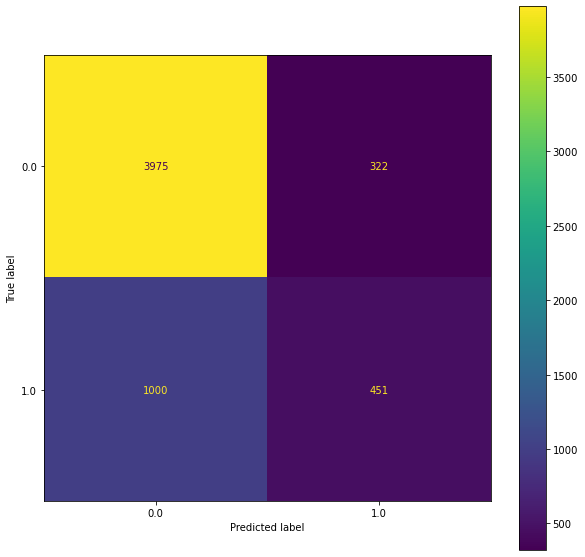

In [53]:


fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logreg, X_test, y_test, ax=ax)  
plt.show()  

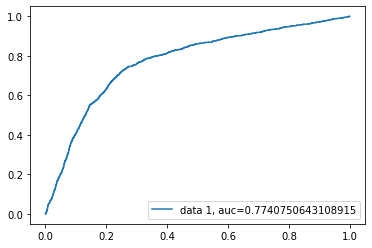

In [37]:

y_pred_proba = logreg.predict_proba(X_test)[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Logistic Regression (Optimized using RFE)

In [109]:
# Recursive Feature Elimination - iterate thru features and 
# Using RFE to prioritize variables based on feature importance (default uses coef_ or feature_importances_)


#identify top x most significant features (default uses half)
rfe = RFE(logreg, 70) 
rfe = rfe.fit(X_train, y_train)

print(rfe.support_) # True == recommend to include
print(rfe.ranking_) # lower number is better (1 is best)

e:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_features_to_select=70 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


[False False  True  True False  True False  True False  True False  True
 False False  True False False False  True  True False  True False False
  True  True False False False False False  True  True  True False False
  True  True  True  True  True False  True False  True  True  True False
 False  True False  True False  True False False False  True  True  True
 False False  True False  True False False False False False False  True
 False False  True  True  True  True False  True False False False False
  True False  True  True  True False False False  True  True  True False
 False  True  True False False False  True False False  True  True False
 False False False  True  True  True False  True False  True  True False
 False False False False False  True False  True False False  True  True
 False  True False  True False False False False False False  True False
 False False False False False False False False False False  True False
 False False False False False False  True False  T

In [110]:
# Let's make the results more human readable
rfe_df = pd.DataFrame([columns,rfe.support_,rfe.ranking_]).T
rfe_df.columns = ['name','support','rank']
rfe_df

,name,support,rank
0,city_city_1,False,6
1,city_city_10,False,45
2,city_city_100,True,1
3,city_city_101,True,1
4,city_city_102,False,64
...,...,...,...
181,last_new_job_4,False,90
182,last_new_job_>4,False,92
183,last_new_job_never,True,1
184,city_development_index,True,1


In [111]:
# List of recommended variables
rfe_df[rfe_df['support']==True]

,name,support,rank
2,city_city_100,True,1
3,city_city_101,True,1
5,city_city_103,True,1
7,city_city_105,True,1
9,city_city_107,True,1
...,...,...,...
164,company_size_10/49,True,1
168,company_size_50-99,True,1
173,company_type_Funded Startup,True,1
183,last_new_job_never,True,1


In [112]:
rfe_df[rfe_df['support']==True]['name'].values

array(['city_city_100', 'city_city_101', 'city_city_103', 'city_city_105',
       'city_city_107', 'city_city_11', 'city_city_115', 'city_city_12',
       'city_city_120', 'city_city_123', 'city_city_128', 'city_city_129',
       'city_city_138', 'city_city_139', 'city_city_14', 'city_city_142',
       'city_city_143', 'city_city_144', 'city_city_145', 'city_city_146',
       'city_city_150', 'city_city_155', 'city_city_157', 'city_city_158',
       'city_city_160', 'city_city_165', 'city_city_167', 'city_city_176',
       'city_city_179', 'city_city_18', 'city_city_2', 'city_city_21',
       'city_city_30', 'city_city_36', 'city_city_37', 'city_city_39',
       'city_city_40', 'city_city_42', 'city_city_48', 'city_city_53',
       'city_city_54', 'city_city_55', 'city_city_62', 'city_city_64',
       'city_city_65', 'city_city_7', 'city_city_70', 'city_city_74',
       'city_city_77', 'city_city_78', 'city_city_82', 'city_city_83',
       'city_city_84', 'city_city_9', 'city_city_91',

# Remodel using prioritized features

In [113]:
prioritized_features = rfe_df[rfe_df['support']==True]['name'].values
prioritized_X_train = X_train[prioritized_features]

In [114]:
logreg2 = LogisticRegression(random_state=0,solver='liblinear',max_iter=100)
logreg2.fit(prioritized_X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [115]:
# predictions
prioritized_y_pred = logreg2.predict(X_test[prioritized_features])
prioritized_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

# Model Metrics

In [116]:
# Sample output
# feature importance
logreg2.coef_

array([[ 0.84477425,  0.64354589,  0.79879992, -0.68192164,  0.53904687,
         0.95548382,  0.42960918, -0.7062409 , -0.43385832,  0.35795344,
         0.67394749, -0.63291872, -0.42980162,  0.52011811,  0.56687866,
         0.62140332,  0.47291595,  0.65793946,  0.8937453 ,  0.42479955,
        -0.62957271,  1.15419942, -1.16227518,  0.63659084,  0.88608806,
         1.04148525,  0.8783586 ,  0.58319801,  0.35670591,  0.4810599 ,
        -0.53274141,  1.25984664, -0.93636223, -0.46498285, -0.67102569,
        -0.34714362, -0.59903918,  0.5014711 ,  0.4719127 ,  0.53174319,
         0.41871691,  0.33066311, -0.68442862, -0.82089946, -0.44906976,
        -0.40742527,  0.55927778,  0.55503329, -0.75391125,  0.60040642,
        -0.49131471,  0.51206953,  0.45870759,  0.79518113,  0.38797282,
         0.39107426,  0.35057051,  0.50485826, -0.36893825,  0.74621976,
         0.64026509, -0.43483487,  0.33679822,  0.58321718,  0.33403846,
         0.34826297,  0.89744536, -0.55824906, -0.4

In [117]:
accuracy_score(prioritized_y_pred, y_test) # it's SLIGHTLY more accurate but uses LESS resources 

0.7719206680584552

In [118]:
precision_score(prioritized_y_pred,y_pred)

0.9120310478654593

In [119]:
recall_score(y_test,y_pred)

0.3108201240523777

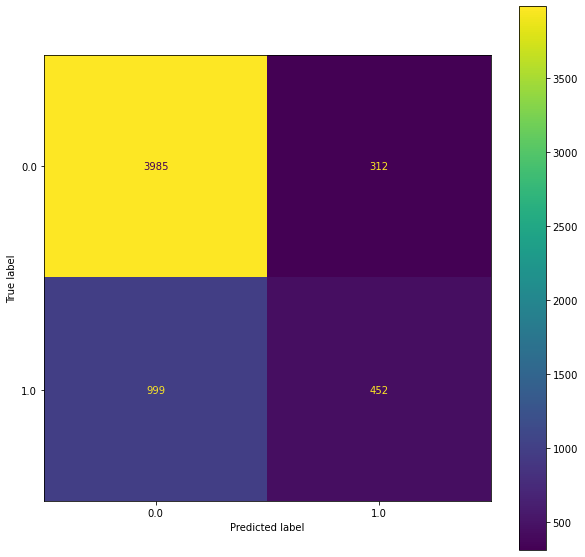

In [120]:
# confusion matrix
fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(logreg2, X_test[prioritized_features], y_test, ax=ax)  
plt.show()  

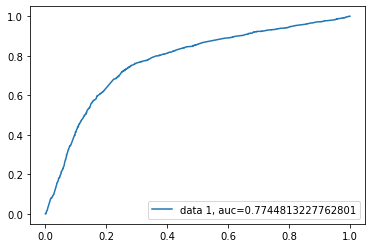

In [121]:

y_pred_proba = logreg2.predict_proba(X_test[prioritized_features])[::,1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
auc = roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr, tpr, label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Model output and Persistence

In [125]:
# pickle can also be a good alternative to joblib 

# how to save and load model
finalmodel = logreg2
filename = 'hr_logreg.mdl'
dump(finalmodel, filename)

# how to load the model
finalmodel = load(filename) 
finalmodel.coef_

array([[ 0.84477425,  0.64354589,  0.79879992, -0.68192164,  0.53904687,
         0.95548382,  0.42960918, -0.7062409 , -0.43385832,  0.35795344,
         0.67394749, -0.63291872, -0.42980162,  0.52011811,  0.56687866,
         0.62140332,  0.47291595,  0.65793946,  0.8937453 ,  0.42479955,
        -0.62957271,  1.15419942, -1.16227518,  0.63659084,  0.88608806,
         1.04148525,  0.8783586 ,  0.58319801,  0.35670591,  0.4810599 ,
        -0.53274141,  1.25984664, -0.93636223, -0.46498285, -0.67102569,
        -0.34714362, -0.59903918,  0.5014711 ,  0.4719127 ,  0.53174319,
         0.41871691,  0.33066311, -0.68442862, -0.82089946, -0.44906976,
        -0.40742527,  0.55927778,  0.55503329, -0.75391125,  0.60040642,
        -0.49131471,  0.51206953,  0.45870759,  0.79518113,  0.38797282,
         0.39107426,  0.35057051,  0.50485826, -0.36893825,  0.74621976,
         0.64026509, -0.43483487,  0.33679822,  0.58321718,  0.33403846,
         0.34826297,  0.89744536, -0.55824906, -0.4

# What's Next?

Feel free to explore the basics of Python and development for data science using the following repositories:
 - https://github.com/ogbinar/python101
 - https://github.com/ogbinar/python_ds
 - https://github.com/ogbinar/python_ml
 - https://github.com/ogbinar/python_deployment